###  트랜스포머 모델 구조

![트랜스포머의 구조](https://user-images.githubusercontent.com/70866993/137133384-41455053-ddbc-4089-a778-42819bb902ca.jpg)

[Positional Encoding]
- <a href="https://skyjwoo.tistory.com/31" target="_blank"> Positional Encoding이란? </a> : 문장에 연속성을 부여하는 새로운 방법을 제시, 각 단어의 위치와 시퀀스 내의 다른 단어간의 위치 차이에 대한 정보를 알수 있게 한다.
- 방법 1) 각 단어에 0~1 사이의 값을 더한다. 0을 첫 번째 단어로, 1을 마지막 단어로 한다.
    -> 문장의 길이에 따라 더해지는 값이 가변적이다. 따라서 단어 간의 거리(Delta)가 일정하지 않다.
- 방법 2) 각 단어에 선형적으로 증가하는 정수를 더한다.
    -> 단어 간의 거리(Delta)가 일정해지는 것은 좋지만 범위가 무제한이기 때문에 값이 매우 커질 수 있고 모델이 일반화하기 어려워진다.
- 만족조건 4가지
    - 각 Time-step마다 고유의 Encoding 값을 출력
    - 서로 다른 Time-step이라도 같은 거리라면 차이가 일정
    - 순서를 나타내는 값이 특정 범위 내에서 일반화가 가능
    - 같은 위치라면 언제든 같은 값을 출력

[Positional Encoding] 수식

![Positional Encoding](https://user-images.githubusercontent.com/70866993/137666368-143000ab-dc64-45a6-891c-60c38ff95865.JPG)

$pos$는 단어가 위치한 Time-step을 의미, $i$는 Encoding 차원의 Index, $D_{model}$은 모델의 Embedding 차원 수입니다. 이를 Sinusoid(사인파) Embedding이라고 한다.

In [1]:
import numpy as np

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

pos = 7
d_model = 4
i = 0

print("Positional Encoding 값:\n", positional_encoding(pos, d_model))

print("")
print("if pos == 0, i == 0: ", np.sin(0 / np.power(10000, 2 * i / d_model)))
print("if pos == 1, i == 0: ", np.sin(1 / np.power(10000, 2 * i / d_model)))
print("if pos == 2, i == 0: ", np.sin(2 / np.power(10000, 2 * i / d_model)))
print("if pos == 3, i == 0: ", np.sin(3 / np.power(10000, 2 * i / d_model)))

print("")
print("if pos == 0, i == 1: ", np.cos(0 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 1, i == 1: ", np.cos(1 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 2, i == 1: ", np.cos(2 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 3, i == 1: ", np.cos(3 / np.power(10000, 2 * i + 1 / d_model)))

Positional Encoding 값:
 [[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.99500417  0.00999983  0.9999995 ]
 [ 0.90929743  0.98006658  0.01999867  0.999998  ]
 [ 0.14112001  0.95533649  0.0299955   0.9999955 ]
 [-0.7568025   0.92106099  0.03998933  0.999992  ]
 [-0.95892427  0.87758256  0.04997917  0.9999875 ]
 [-0.2794155   0.82533561  0.05996401  0.999982  ]]

if pos == 0, i == 0:  0.0
if pos == 1, i == 0:  0.8414709848078965
if pos == 2, i == 0:  0.9092974268256817
if pos == 3, i == 0:  0.1411200080598672

if pos == 0, i == 1:  1.0
if pos == 1, i == 1:  0.9950041652780258
if pos == 2, i == 1:  0.9800665778412416
if pos == 3, i == 1:  0.955336489125606


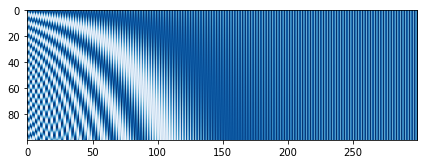

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.imshow(positional_encoding(100, 300), cmap='Blues')
plt.show()

###  Multi-Head Attention
- Positional Embedding이 된 문장으로부터 Attention을 추출하는 부분
    - Linear 레이어와 <a href="https://reniew.github.io/43/" target="_blank"> Scaled Dot-Product Attention</a>레이어로 이루어 진다.
    - Multi-Head Attention에서 Head는 주로 8개를 사용E
    - mbedding된 10개 단어의 문장이 [10, 512]의 형태를 가진다면, Multi-Head Attention은 이를 [10, 8, 64]로 분할하여 연산합니다. 
    - 각 64차원의 Embedding을 독립적으로 Attention한 후, 이를 이어붙여 다시금 [10, 512]의 형태로 되돌리며 연산은 끝이 납니다.
        - Head로 쪼갠 Embedding들끼리 유사한 특성을 가진다는 보장이 없기 때문에 앞단에 Linear 레이어를 추가 
        - Linear 레이어는 Multi-Head Attention이  잘 동작할수 있는 적합한 공간으로 임배딩 매핑 시키는 역할
![multi head attention](https://user-images.githubusercontent.com/70866993/137685642-8297c9d1-9522-4d80-8924-920a31390e88.jpg)

-  Multi-head attention : 전체 dimension에 대해서 한번 attention을 적용하는 것이 아니라 전체 dimension을 h로 나눠서 attention을 h번 적용시키는 방법
    - 각 query, key, value의 vector는 linearly하게 h개로 project 된다.하나의 Query와 모든 Key들 사이의 연관성(유사도)을 계산한 후 그 값을 확률 값으로 만든다. Query와 어떤 Key와 높은 확률로 연관이 있는지 계산한다.
        - 이후 각각 나눠서 attention을 시킨 후 만들어진 h개의 vector를 concat하면 된다.
            - 마지막으로 vector의 dimension을 $d_{model}$로 다시 맞춰주도록 matrix를 곱하면 끝난다
- Embedding 차원 수가 깊어질수록 Dot-Product의 값은 커저셔 Softmax 값을 거치고 나면 미분값이 작아지는 것을 방지하기 위해 Scale 작업이 필요하다.
    -Embedding의 깊이가 깊을수록 모델의 시야가 편협해지는 문제가 생긴다. 

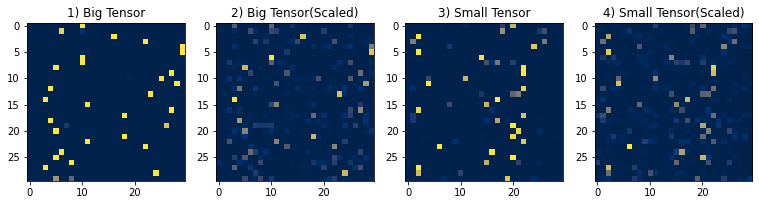

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])

    return tf.tensordot(A, B, axes=1)

length = 30
big_dim = 1024.
small_dim = 10.

big_tensor = make_dot_product_tensor((length, int(big_dim)))
scaled_big_tensor = big_tensor / tf.sqrt(big_dim)
small_tensor = make_dot_product_tensor((length, int(small_dim)))
scaled_small_tensor = small_tensor / tf.sqrt(small_dim)

fig = plt.figure(figsize=(13, 6))

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.set_title('1) Big Tensor')
ax2.set_title('2) Big Tensor(Scaled)')
ax3.set_title('3) Small Tensor')
ax4.set_title('4) Small Tensor(Scaled)')

ax1.imshow(tf.nn.softmax(big_tensor, axis=-1).numpy(), cmap='cividis')
ax2.imshow(tf.nn.softmax(scaled_big_tensor, axis=-1).numpy(), cmap='cividis')
ax3.imshow(tf.nn.softmax(small_tensor, axis=-1).numpy(), cmap='cividis')
ax4.imshow(tf.nn.softmax(scaled_small_tensor, axis=-1).numpy(), cmap='cividis')

plt.show()

![트랜스포머_인과관계마스킹ㅡ](https://user-images.githubusercontent.com/70866993/137685024-77d57486-2403-4147-a3df-149ed3c2dc41.jpg)
- 보라색 영역 인과 관계 마스킹(Causality Masking)이라는 과정이 하나 더 추가
    - 인과 관계 마스킹 : 목표하는 문장의 일부를 가려 인위적으로 연속성을 학습하게 하는 방법
    - 자기 회귀적 문장생성, 대각항을 포함하지 않는 삼각 행렬의 모양새를 갖느다.


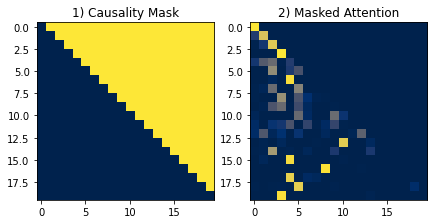

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])

    return tf.tensordot(A, B, axes=1)

def generate_causality_mask(seq_len):
    mask = 1 - np.cumsum(np.eye(seq_len, seq_len), 0)
    return mask

sample_tensor = make_dot_product_tensor((20, 512))
sample_tensor = sample_tensor / tf.sqrt(512.)

mask = generate_causality_mask(sample_tensor.shape[0])

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('1) Causality Mask')
ax2.set_title('2) Masked Attention')

ax1.imshow((tf.ones(sample_tensor.shape) + mask).numpy(), cmap='cividis')

mask *= -1e9
ax2.imshow(tf.nn.softmax(sample_tensor + mask, axis=-1).numpy(), cmap='cividis')

plt.show()

### Position-wise Feed-Forward Networks
- position 마다, 즉 개별 단어마다 적용되기 때문에 <a href="https://pozalabs.github.io/transformer/" target="_blank">position-wise</a> 입니다.
- network는 두 번의 linear transformation과 activation function ReLU로 이루어져 있습니다.
$FFN(x) = max(0,xW_1+b_1)+W_2+b_2$
    - x 에 linear transformation을 적용한 뒤, $ReLU(max(0,z))$ 를 거쳐 다시 한번 linear transformation을 적용
    - 이때 각각의 position마다 같은 parameter $W,b$를 사용하지만, <mark>layer가 달라지면 다른 parameter를 사용</mark>
    - kernel size가 1이고 channel이 layer인 convolution을 두 번 수행한 것으로도 위 과정을 이해
        - 즉, 한 단어를 Embedding 차원만큼의 채널을 갖는 한칸짜리 이미지라고 취급
![feed forward network](https://user-images.githubusercontent.com/70866993/137768669-2717de58-4dd9-4b76-8972-1f51e2b5ad5a.jpg)

- <a href="https://ai.googleblog.com/2019/06/applying-automl-to-transformer.html" target="_blank"> 진화된 트렌스포머 읽어보기 (영문)</a>

### Additional Techniques 
- 이미지 상에 Add & Norm 영역 보기
- Layer Normalization은 데이터를 Feature 차원에서 정규화를 하는 방법
    - 10단어의 Embedding된 문장을 예로 [10, 512]에서 512차원 Feature를 정규화하여 분포를 일정하게 맞춰주는 것

<a href="https://subinium.github.io/introduction-to-normalization/" target="blank"> [정규화 종류] </a> 
- Normalization(정규화) : 데이터 처리에 있어 각 특성의 스케일을 조정한다는 의미로, feature scaling
- Regularization(정규화/일반화) : 보통 모델의 설명도를 유지하면서 모델의 복잡도를 줄이는 방식
    - Early stopping, Noisy input, drop-out, Pruning & feature selection, emsemble
- Standardization(표준화) :  Standard Scaler 또는 z-score normalization 을 의미
    - 기존 데이터를 평균 0, 표준 편차 1인 표준분포의 꼴 데이터로 만드는 것을 의미
    - 평균을 기준으로 얼마나 떨어져 있는지 살펴볼 때 보통 사용, 보통 데이터 분포가 가우시안 분포 따를때 유용
    
-  Batch Normalization :  정규화를 Batch 차원에서 진행
    - Gradient Vanishing / Gradient Exploding이 일어나지 않도록 하는 아이디어 중의 하나
    - Gradient Vanishing : 신경망에서 손실 함수의 gradient 값이 0에 근접하며, 훈련을 하기 힘들어지는 문제
    - Gradient Exploding : 심층 신경망 또는 RNN에서 error gradient가 축적되어, 가중치 업데이트시 overflow되거나 NaN값이 되는 현상
-  Layer Normalization: 정규화를 Feature 차원에서 진행

<a href="https://itrepo.tistory.com/36" target="blank"> [ResNet] </a>
- 컴퓨터 비전에서는 트랜스포머만큼이나 유명한 모델, =Skip Connection
- 네트워크가 깊어질 수록 Optimize(Train)하는 것이 어렵기 때문에, 얕은 네트워크가 더 좋은 성능을 보이게 된다.
- Residual Block은 굉장히 간단한 수식으로 표현이 가능 : y = f(x) + x

#### Learning Rate Schedular
- 트랜스포머를 훈련하는 데에는 Adam Optimizer를 사용했는데, 특이한 점은 Learning Rate를 수식에 따라 변화시키며 사용했다는 것
- 위 수식을 따르게 되면 warmup\_stepswarmup_steps까지는 lratelrate가 선형적으로 증가 하고, 이후에는 step\_numstep_num에 비례해 점차 감소하는 모양새 를 보이게 됩니다.

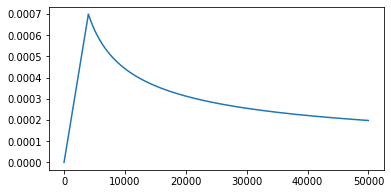

In [4]:
import matplotlib.pyplot as plt
import numpy as np

d_model = 512
warmup_steps = 4000

lrates = []
for step_num in range(1, 50000):
    lrate = (np.power(d_model, -0.5)) * np.min(
        [np.power(step_num, -0.5), step_num * np.power(warmup_steps, -1.5)]) #학습 초반과 후반 armup_steps 값에 따라 결정
    lrates.append(lrate)

plt.figure(figsize=(6, 3))
plt.plot(lrates)
plt.show()

- Learning Rate를 사용하면 초반 학습이 잘되지 않은 상태에서의 학습 효율이 늘어나고, 어느 정도 학습이 된 후반에는 디테일한 튜닝을 통해 Global Minimum을 찾아가는 효과가 나게 됩니다. 학습의 초반과 후반은 warmup_steps 값에 따라 결정

#### Weight Sharing
- Weight Sharing은 모델의 일부 레이어가 동일한 사이즈의 Weight를 가질 때 종종 등장하는 테크닉
- 하나의 Weight를 두 개 이상의 레이어가 동시에 사용하도록 하는 것인데, 대표적으로 언어 모델의 Embedding 레이어와 최종 Linear 레이어가 동일한 사이즈의 Weight를 가집니다. =Call By Reference 의 개념과 비슷하다
- 트랜스포머에서는 Decoder의 Embedding 레이어와 출력층 Linear 레이어의 Weight를 공유하는 방식을 사용
    - 언어의 유사성에 따라서 선택적으로 사용합니다. 만일 소스와 타겟 Embedding 층까지 공유한다면 3개의 레이어가 동일한 Weight를 사용하는 셈
    - 출력층 Linear 레이어와 Embedding 레이어의 Feature 분포가 다르므로 Embedding 된 값에 $d_{model}$ 의 제곱근 값을 곱해줍니다. 이는 분포를 맞춰줌과 동시에 Positional Encoding이 Embedding 값에 큰 영향을 미치는 것을 방지

###  트랜스포머, 그 후엔
- <a href="https://ratsgo.github.io/nlpbook/docs/language_model/bert_gpt/#gpt" target="_blank"> GPT와 BERT</a>

[GPT와 BERT의 차이점에 대해 3가지]
1) GPT는 단방향 Attention을 사용하지만 BERT는 양방향 Attetion을 사용한다.
2) GPT는 트랜스포머에서 디코더(decoder)만 사용하고 BERT는 인코더(encoder)만 사용한다.
3) GPT는 문장을 생성할 수 있지만 BERT는 문장의 의미를 추출하는 데 강점을 가지고 있다

- Reformer는 트랜스포머를 연산량 측면에서 혁신적으로 개선한 모델 
  - https://brunch.co.kr/@synabreu/31
- 월간 자연어 처리 - MHA
    - https://www.facebook.com/permalink.php?story_fbid=156092245822648&id=111809756917564 
- [논문] Are Sixteen Heads Really Better than One
    - https://littlefoxdiary.tistory.com/m/66?category=847374